## SageMaker Feature Store with Titanic


In [1]:
%%html
<style>
table {float:left}
</style>

In [32]:
!pip install awswrangler --quiet


### Prerequisites
This notebook uses both `boto3` and Python SDK libraries, and the `Python 3 (Data Science)` kernel. 

#### Library dependencies:
* `sagemaker>=2.100.0`
* `numpy`
* `pandas`

#### IAM Role besides SageMaker Execcution Role

* `AmazonS3FullAccess`
* `AmazonSageMakerFeatureStoreAccess`

### Default SageMaker Bucket

Set to SageMaker session explicitly.

# Set up

In [2]:
!pip install 'sagemaker>=2.100.0' --quiet
!pip install 'boto3>=1.24.20' --quiet

In [3]:
# SageMaker Python SDK version 2.100.0 is required
# boto3 version 1.24.20 is required
import time
from time import gmtime, strftime, sleep
import sys
import io

In [44]:
import pandas as pd
import numpy as np

import sagemaker
import boto3
import awswrangler as wr  
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import (
    FeatureGroup
)

In [5]:
DEFAULT_BUCKET = "montaproxy-sagemaker-featurestore-test"

In [6]:
role = get_execution_role()

sagemaker_session = sagemaker.Session(default_bucket=DEFAULT_BUCKET)
region = sagemaker_session.boto_region_name
s3_bucket_name = sagemaker_session.default_bucket()
prefix = "oonisim-kaggle-titanic-feature-group"

print(f"s3_bucket_name={s3_bucket_name}")
print(f"region={region}")
print(f"role={role}")

s3_bucket_name=montaproxy-sagemaker-featurestore-test
region=us-east-1
role=arn:aws:iam::316725000538:role/service-role/AmazonSageMaker-ExecutionRole-20250813T120418


# Raw Data

In [7]:
titanic_df = pd.read_csv("s3://montaproxy-datazone-test/kaggle/titanic/train.csv")

In [8]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Append dummy `event_timestamp` feature to dataframe. This parameter is required, and time stamps each data point.

In [9]:
event_timestamp = int(round(time.time()))

In [10]:
titanic_df["EventTime"] = pd.Series([event_timestamp] * len(titanic_df), dtype="float64")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,EventTime
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1.755121e+09
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.755121e+09
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.755121e+09
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.755121e+09
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1.755121e+09


# Feature Engineering

TBD

# Feature Registration (Feature Group)

Similar to Feature Service in FEAST to expose a logical group of features for a model version to consume. (To be verified).


In [11]:
titanic_feature_group_name = "oonisim-kaggle-titanic-feature-group"
record_identifier_feature_name = "PassengerId"

In [12]:
titanic_feature_group = FeatureGroup(
    name=titanic_feature_group_name,
    sagemaker_session=sagemaker_session
)

### Load feature definitions into the feature group

Inspect the dataframe schema and generate Feature Definitions of the Feature Group.

In [13]:
titanic_df_feature_definitions = titanic_feature_group.load_feature_definitions(data_frame=titanic_df)
titanic_df_feature_definitions

[FeatureDefinition(feature_name='PassengerId', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Survived', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Pclass', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Name', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='Sex', feature_type=<FeatureTypeEnum.STRING: 'String'>, collection_type=None),
 FeatureDefinition(feature_name='Age', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='SibSp', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Parch', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='Ticket', feature_type=<Feature

### Create Feature Group

In [16]:
# titanic_feature_group.delete()
titanic_feature_group.create(
    s3_uri=f"s3://{s3_bucket_name}/{titanic_feature_group_name}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True,
)

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:316725000538:feature-group/oonisim-kaggle-titanic-feature-group',
 'ResponseMetadata': {'RequestId': '6d630e38-a0d6-4fda-bd87-01406f06c7f4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6d630e38-a0d6-4fda-bd87-01406f06c7f4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '113',
   'date': 'Wed, 13 Aug 2025 21:41:40 GMT'},
  'RetryAttempts': 0}}

### Verify Feature Group

Use `DescribeFeatureGroup` and `ListFeatureGroups` APIs to display the created FeatureGroup.

In [17]:
def check_feature_group_status(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group to be Created")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    print(f"FeatureGroup {feature_group.name} successfully created.")


check_feature_group_status(titanic_feature_group)

Waiting for Feature Group to be Created
Waiting for Feature Group to be Created
FeatureGroup oonisim-kaggle-titanic-feature-group successfully created.


In [18]:
titanic_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:316725000538:feature-group/oonisim-kaggle-titanic-feature-group',
 'FeatureGroupName': 'oonisim-kaggle-titanic-feature-group',
 'RecordIdentifierFeatureName': 'PassengerId',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'PassengerId',
   'FeatureType': 'Integral'},
  {'FeatureName': 'Survived', 'FeatureType': 'Integral'},
  {'FeatureName': 'Pclass', 'FeatureType': 'Integral'},
  {'FeatureName': 'Name', 'FeatureType': 'String'},
  {'FeatureName': 'Sex', 'FeatureType': 'String'},
  {'FeatureName': 'Age', 'FeatureType': 'Fractional'},
  {'FeatureName': 'SibSp', 'FeatureType': 'Integral'},
  {'FeatureName': 'Parch', 'FeatureType': 'Integral'},
  {'FeatureName': 'Ticket', 'FeatureType': 'String'},
  {'FeatureName': 'Fare', 'FeatureType': 'Fractional'},
  {'FeatureName': 'Cabin', 'FeatureType': 'String'},
  {'FeatureName': 'Embarked', 'FeatureType': 'String'},
  {'FeatureName': 'EventTime', 'FeatureType': 'Fract

### Add metadata to a feature

We can add searchable metadata fields to FeatureGroup features by using the `UpdateFeatureMetadata` API. The currently supported metadata fields are `description` and `parameters`.

To view feature metadata, we can use `DescribeFeatureMetadata` to display that feature.

Feature metadata fields are searchable. We use `search` API to find features with metadata that matches some search criteria.

## Materialise Feature Group

Materialise the Feature Group by loading the Datastore contents via the `PutRecord` API.

In [23]:
response = titanic_feature_group.ingest(data_frame=titanic_df, max_workers=3, wait=True)

In [49]:
# print(response)

Use `get_record` to check that the record for the passenger id 5 has been ingested into the feature group.

In [25]:
passenger_id = 5
sample_record = sagemaker_session.boto_session.client(
    "sagemaker-featurestore-runtime", region_name=region
).get_record(
    FeatureGroupName=titanic_feature_group_name, RecordIdentifierValueAsString=str(passenger_id)
)

In [26]:
sample_record

{'ResponseMetadata': {'RequestId': '6500a9b0-5b7b-4417-b31a-1ac6b748ab46',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6500a9b0-5b7b-4417-b31a-1ac6b748ab46',
   'content-type': 'application/json',
   'content-length': '917',
   'date': 'Wed, 13 Aug 2025 21:42:32 GMT'},
  'RetryAttempts': 0},
 'Record': [{'FeatureName': 'PassengerId', 'ValueAsString': '5'},
  {'FeatureName': 'Survived', 'ValueAsString': '0'},
  {'FeatureName': 'Pclass', 'ValueAsString': '3'},
  {'FeatureName': 'Name', 'ValueAsString': 'Allen, Mr. William Henry'},
  {'FeatureName': 'Sex', 'ValueAsString': 'male'},
  {'FeatureName': 'Age', 'ValueAsString': '35.0'},
  {'FeatureName': 'SibSp', 'ValueAsString': '0'},
  {'FeatureName': 'Parch', 'ValueAsString': '0'},
  {'FeatureName': 'Ticket', 'ValueAsString': '373450'},
  {'FeatureName': 'Fare', 'ValueAsString': '8.05'},
  {'FeatureName': 'Embarked', 'ValueAsString': 'S'},
  {'FeatureName': 'EventTime', 'ValueAsString': '1755121259.0'}]}

Use `batch_get_record` to check multiple records.

In [ ]:
all_records = sagemaker_session.boto_session.client(
    "sagemaker-featurestore-runtime", region_name=region
).batch_get_record(
    Identifiers=[
        {
            "FeatureGroupName": titanic_feature_group_name,
            "RecordIdentifiersValueAsString": ["1", "2", "3"],
        },
    ]
)

In [50]:
# all_records

---
# Consumption

## Feature Group Glue Catalog Table

Feature Group is registered as the Glue Catalog Table at its creation and ready to query.

| Feature Group Glue Catalog Table                | Glue Catalog Database  | Offline Store Location                                                                                                                                                                |
|-------------------------------------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| oonisim_kaggle_titanic_feature_group_1755074813 | sagemaker_featurestore | s3://montaproxy-sagemaker-featurestore-test/oonisim-kaggle-titanic-feature-group/316725000538/sagemaker/us-east-1/offline-store/oonisim-kaggle-titanic-feature-group-1755074813/data/ |

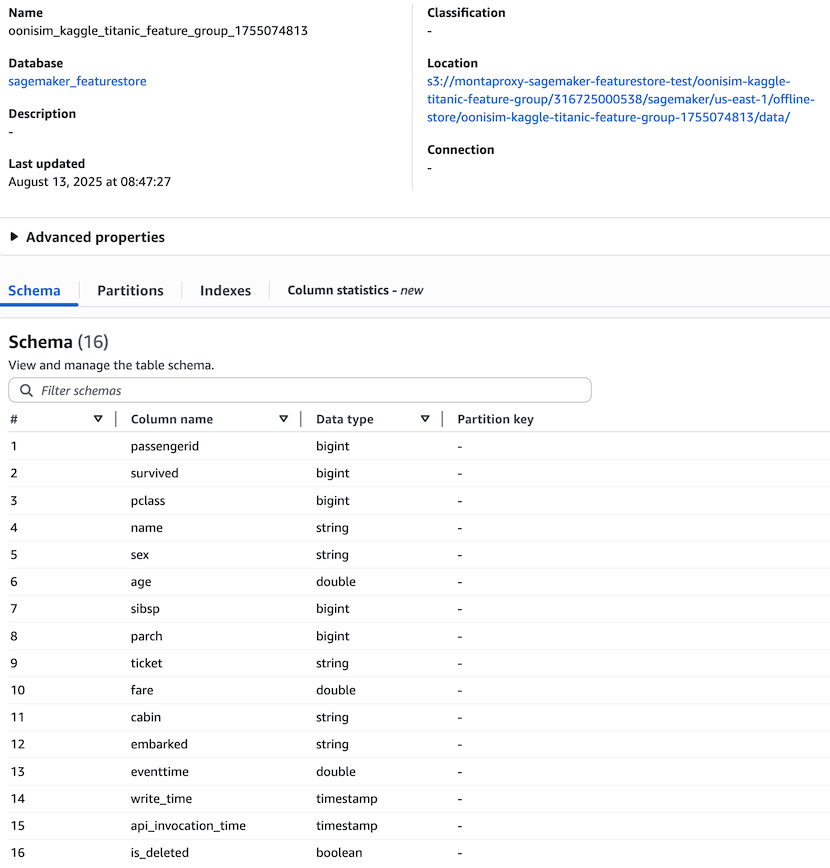

## Query from Glue Catalog Table

In [51]:
database = "sagemaker_featurestore"
table = "oonisim_kaggle_titanic_feature_group_1755074813"

In [52]:
sql = f"""
SELECT *
FROM {table}
"""
df = wr.athena.read_sql_query(sql=sql, database=database)

2025-08-13 22:19:05,691	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 893366272 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.13gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-08-13 22:19:06,971	INFO worker.py:1852 -- Started a local Ray instance.


In [53]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,eventtime,write_time,api_invocation_time,is_deleted
0,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,<NA>,S,1.755074e+09,2025-08-13 08:58:15.541,2025-08-13 08:53:17,False
1,416,0,3,"Meek, Mrs. Thomas (Annie Louise Rowley)",female,NaN,0,0,343095,8.0500,<NA>,S,1.755074e+09,2025-08-13 08:58:15.541,2025-08-13 08:53:17,False
2,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,<NA>,S,1.755074e+09,2025-08-13 08:58:15.541,2025-08-13 08:53:17,False
3,548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,<NA>,C,1.755074e+09,2025-08-13 08:58:15.541,2025-08-13 08:53:18,False
4,549,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,363291,20.5250,<NA>,S,1.755074e+09,2025-08-13 08:58:15.541,2025-08-13 08:53:18,False


## Model Training

TBD

---
# Clean up
Remove the Feature Groups we created. 

In [ ]:
titanic_feature_group.delete()